# TensorFlow の学習済みモデルをデプロイ

このノートブックでは [Github](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) で公開されている学習済みの TensorFlow モデルを SageMaker にデプロイします。モデルは TensorFlow SavedModel 形式である必要があり、以下のファイル構成でモデルを tar.gz 形式に圧縮してデプロイに利用します。詳細は[こちら](https://aws.amazon.com/jp/blogs/news/amazon-sagemaker-%E3%81%A7%E8%A4%87%E6%95%B0%E3%81%AE-tensorflow-%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E4%B8%80%E3%81%A4%E3%81%AE%E3%82%A8%E3%83%B3%E3%83%89%E3%83%9D%E3%82%A4%E3%83%B3%E3%83%88%E3%81%B8/)を御覧ください。

```
model
  └── 1
      ├── saved_model.pb
      └── variables
          ├── variables.data-00000-of-00001
          └── variables.index
```

まずは公開されているファイルをダウンロードして上に示すようなファイル構造にします。そして tar.gz の形式に圧縮します。

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar xvzf efficientdet_d0_coco17_tpu-32.tar.gz
!mkdir -p model/1
!mv efficientdet_d0_coco17_tpu-32/saved_model/* ./model/1/
!tar cvzf model.tar.gz model

デプロイするために圧縮したファイルをS3にアップロードします。

In [ ]:
import sagemaker
sagemaker_session = sagemaker.Session()
model_data = sagemaker_session.upload_data("./model.tar.gz", key_prefix="pretrained_models/efficientdet")

アップロードしたファイルを指定してデプロイを行います。

In [ ]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(model_data=model_data, 
                        role=sagemaker.get_execution_role(),
                       framework_version='2.1')

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

エンドポイントに犬の画像データを送ってみて、正しく検出できるかどうかを確認します。画像サイズをやや小さくリサイズして、predict関数でエンドポイントに送ります。結果は json 形式で受け取ることができます。json に含まれるキーや値については学習済みモデルに定義されています。[TensorFlow のドキュメント](https://www.tensorflow.org/hub/tutorials/object_detection?hl=ja)からも確認できます。


In [ ]:
!wget https://media.amazonwebservices.com/blog/2018/sg_box_cso_guard_1.jpg

In [ ]:
from PIL import Image
import numpy as np

image = Image.open('sg_box_cso_guard_1.jpg')
width, height = image.size 
image = image.resize((width//3, height//3))
np_image = np.array(image).astype(int)
result = predictor.predict({'instances': [np_image.tolist()]})

bounding box を取得します。

In [ ]:
confident_index = np.where(np.array(result['predictions'][0]['detection_scores'])>0.8)
box_list =[]
for i in confident_index:
    box = result['predictions'][0]['detection_boxes'][i[0]]
    box_list.append(box)

クラスのラベルも取得してbounding box とともに表示します。

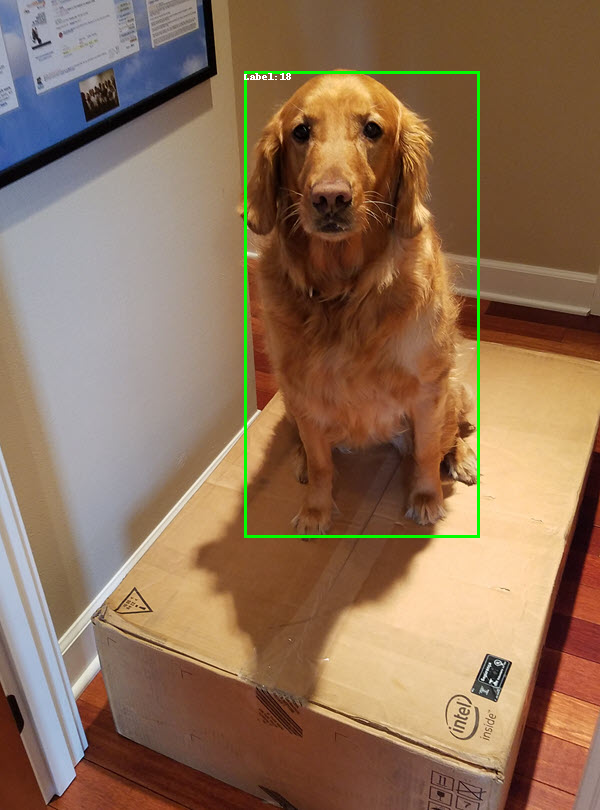

In [40]:
from PIL import Image, ImageDraw
image = Image.open('sg_box_cso_guard_1.jpg')
draw = ImageDraw.Draw(image)
for i, box in enumerate(box_list):
    label = result['predictions'][0]['detection_classes'][confident_index[i][0]]
    draw.rectangle(
        [(box[1]*width, box[0]*height), (box[3]*width, box[2]*height)],  outline=(0, 255, 0), width=3
    )
    
    draw.text((box[1]*width, box[0]*height), "Label:{}".format(int(label)))

display(image)

最後に不要なエンドポイントを削除しましょう。

In [9]:
predictor.delete_endpoint()